# Table of Contents


[Definition of Utility Functions](#util_func) <br/>
[Faster R-CNN Implementation](#fasterRCNN): <br/>
- [Baseline Implementation](#fasterRCNN_baseline) <br/>
- [Custom anchor sizes](#custom_anchor) <br/>

<br/><br/>
[YOLOv11 Implementation](#YOLOv11): <br/>
[Appendix A](#AppenA): <br/>

In [29]:
#set up github

## Definition of Utility Functions: <a class="anchor" name="util_func"></a>

In [2]:
import shutil

# !git pull
# !git status

#check remotes
#!git remote -v


def git_push(message, branch):
  #move to git repo before using git commands
  %cd '/content/Object-Detection-Neural-Networks'

  #copy current notebook to cloned git repo
  file_to_copy = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'
  git_repo = '/content/Object-Detection-Neural-Networks'

  #overwrite the file in the local cloned github repo
  shutil.copy(file_to_copy, git_repo)

  !git add 'UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'

  !git commit -a -m "{message}"
  !git push origin "{branch}"

def publish_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git push -u origin "{branch}"

def create_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git checkout -b "{branch}"

In [3]:
%cd '/content/Object-Detection-Neural-Networks'
!git branch

/content/Object-Detection-Neural-Networks
* main


In [4]:
#CURRENT BRANCH
!git switch "setup_wandb"

Branch 'setup_wandb' set up to track remote branch 'setup_wandb' from 'origin'.
Switched to a new branch 'setup_wandb'


In [5]:
git_push("Bug fix the call to visualise_precitions()", "setup_wandb")

In [6]:
import random
import numpy as np
import torch

#print(torch.__version__)
device = torch.device("cuda:0")
print(device)

#the google style guide suggest that a docstring is not necessary for the set_seeds() function
#as it does not meet any of the following critera
#A docstring is mandatory for every function that has one or more of the following properties:
  # - being part of the public API
  # - nontrivial size
  # - non-obvious logic
#https://github.com/google/styleguide/blob/gh-pages/pyguide.md#38-comments-and-docstrings

#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

cuda:0


In [7]:
from torch.utils.data import Dataset
import numpy as np

class UAVImageDataset(Dataset):
    """Overrides the PyTorch Dataset class

      Defines how raw data should be read and transformed ready for model training

      Attributes:
          data_dir_imgs: file string path to raw images
          data_dir_targets: file string path to raw target data
          imgs: the formatted images ready for training
          targets: the formatted targets ready for training
    """

    def __init__(self, data_dir_imgs: str, data_dir_targets: str, transform=None) -> None:
        """Formats the raw images and targets ready for model training

          Images are converted to tensors as required by PyTorch for model training
          All tensor representations of images are stored in a List
          Targets (boxes and labels) are compiled into a dictionary for each image
          All targets are stored in a list
          An image and it's targets are stored at the same index in their respective arrays

        Args:
          data_dir_imgs: a string representing the file path to the image folder of the dataset
          data_dir_targets: a string representing the file path to the 'targets' folder of the dataset
        """

        self.data_dir_imgs = data_dir_imgs
        self.data_dir_targets = data_dir_targets
        self.transforms = transforms

        file_names = os.listdir(path=data_dir_imgs)
        number_of_images = len(file_names)

        self.imgs = []
        self.targets = []

        for i in range(number_of_images):
            img = data_dir_imgs + '/'+ file_names[i]
            img_read = cv2.imread(img)
            image_transform = transforms.ToTensor()  #cv library reads as a numpy array, needs to be a pytorch tensor to be compatible
            img = image_transform(img_read)
            self.imgs.append(img)

            #remove .jpg or .png file extension and retrieve corresponding labels
            with open(data_dir_targets + '/' + file_names[i][:-4]+ '.txt','r') as f:
                file_lines = f.read().splitlines()

                targets = {
                        "boxes": [],
                        "labels": []
                    }

                #.txt label files with no annotations cause training error;
                if len(file_lines) ==0:
                    #follow 2 lines of code sourced from:
                    #https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/13
                    #to address the issue of images with no ground truth bounding boxes
                    targets["boxes"] = torch.as_tensor(np.array(np.zeros((0, 4)), dtype=float))
                    targets["labels"] = torch.as_tensor(np.array([], dtype=int), dtype=torch.int64)
                else:
                    for file_line in file_lines:
                        indiv_items = file_line.split(" ")
                        label, x1, y1, width, height = indiv_items[0], indiv_items[1], indiv_items[2], indiv_items[3], indiv_items[4]
                        label = int(label)
                        x1, width,  = float(x1)*img_read.shape[1], float(width)*img_read.shape[1],
                        y1, height = float(y1)*img_read.shape[0], float(height)*img_read.shape[0]
                        x2 = x1 + width
                        y2 = y1 + height

                        #ADD TRY EXCEPT CLAUSE HERE
                        if x2 < x1 or x1 == x2 or y2 < y1 or y1 == y2:
                            print('Invalid Ground Truth Bounding Box')
                            print(x1, y1, x2, y2)

                        #YOLO label format is x-centre, y-centre, width, height
                        targets['boxes'].append([x1-width/2, y1-height/2, x2-width/2, y2-height/2])
                        targets['labels'].append(label)

                self.targets.append(targets)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.targets[idx]

In [8]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time

#as a utility function to ensure each iteration of Faster R-CNN is trained in the same way
#ie keep the training procedure as a control

#CONTINUE WATCHING THIS VIDEO
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_model(num_epochs: int,
                train_dataset: torch.utils.data.DataLoader,
                val_dataset: torch.utils.data.DataLoader,
                model: torchvision.models.detection,
                optimizer: torch.optim) -> None:
  """Trains the model for the specified number of epochs

    Calls function train_batch to train the model on each batch in an epoch.
    Validation loss is calculated at the end of each epoch
    Training time is recorded for the purposes of evaluation.
    Epoch loss is calculates as the average training loss across batches

    Args:
        num_epochs: the number of epochs to train for,

        train_dataset: the PyTorch DataLoader for the training set,

        val_dataset: the PyTorch DataLoader for the validation set,

        model: the instance of the PyTorch model

        optimizer : any optimizer imported from torch.optim

    Returns:
        None

    Raises:
        None
    """

  start_time = time.time()
  # track losses across each epoch ready to produce graph
  training_losses = []
  val_losses = []
  for epoch in range(num_epochs):
      # simple progress monitor
      print(f'Epoch {epoch} of {num_epochs}')
      # Keep running total of batch losses ready to take average across epoch
      epoch_loss_train = 0
      for batch in train_dataset:
        batch_training_loss = train_batch(batch, model, optimizer)
        epoch_loss_train += batch_training_loss

      # divide total epoch loss by the total number of batches per epoch
      epoch_training_loss = epoch_loss_train/len(train_dataset)
      training_losses.append(epoch_training_loss)
      print(f'Epoch Training loss: {epoch_training_loss}')

      val_loss = evaluate_loss(model, val_dataset_loader)
      val_losses.append(val_loss)
      print(f'Epoch Validation loss: {val_loss}')


  end_time = time.time()
  execution_time = end_time - start_time
  print(f'Training time: {execution_time} seconds')
  plot_loss([i+1 for i in range(num_epochs)], training_losses, val_losses)

          #memory management
          # images = [ t.cpu() for t in images]
          # targets = [ {'boxes':d['boxes'].cpu(), 'labels':d['labels'].cpu()} for d in targets]
          # del images
          # del targets

In [9]:
def train_batch(train_batch: torch.utils.data.dataset.Subset,
                model: torchvision.models.detection,
                optimizer: torch.optim) -> float:
  """Trains the model on a single batch and returns the batch loss

    Calls function format_batch() before training the model on the batch data.
    Total loss is calculated across each of the 4 losses returned by Faster R-CNN
    A backward pass is then completed

    Args:
        train_batch: a subset of the PyTorch dataset

        model: the instance of the PyTorch model

        optimizer : any optimizer imported from torch.optim

    Returns:
        batch loss

    Raises:
        None
    """
  # enforce correct model mode as model will be set to .eval mode to calculate
  # validation loss during training
  model.train()
  # Calculate training loss
  data_dict = format_batch(train_batch, model)
  images, targets = data_dict['images'], data_dict['targets']
  loss_dict = model(images, targets)
  #IS THIS APPROACH COMPARABLE TO LOSS CALCULATION IN YOLO?
  #IN ORDER TO MAKE COMPARISONS BETWEEN ARCHITECTURES
  training_loss = sum(v for v in loss_dict.values())

  # backward pass
  optimizer.zero_grad()
  training_loss.backward()
  optimizer.step()

  #  Convert to a Python Number ready for plotting
  return training_loss.item()
  #TO DO: CALCULATE mAP FOR EACH EPOCH ?
  # is this avg calc correct ?
  # https://datascience.stackexchange.com/questions/92673/should-i-report-loss-on-the-last-batch-or-the-entire-training-dataset

In [10]:
def format_batch(batch: torch.utils.data.dataset.Subset ,
                 model: torchvision.models.detection) -> dict:
  """Formats batch for processing on GPU

    Checks all images and targets are in tensor form ready for training.
    Also moves all images and targets to the same device as the model ready for processing

    Args:
        batch: a subset of the PyTorch dataset

        model: used to determine which device the batch data should be sent to

    Returns:
        dictionary of prepared batch data ; has 2 keys 'images and targets'

    Raises:
        None
    """

  images = []
  targets = []
  device = next(model.parameters()).device

  for img, targets_dict in batch:
      images.append(img)
      #target boxes expected to be of type Tensor
      targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
      targets_dict['labels'] = torch.tensor(targets_dict['labels'])

      # Data type conversions required by Mac GPU 'MPS'
      #format to tensor of dtype float 32 as supported by MPS
      # targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)
      # targets_dict['labels'] = targets_dict['labels'].type(torch.int64)

      targets.append(targets_dict)

  #move relevant data to GPU
  #otherwise error: RuntimeError: Mismatched Tensor types in NNPack convolutionOutput
  images = [ t.to(device) for t in images]
  targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]

  return {'images': images, 'targets': targets}

In [11]:
##THE CODE IN THIS CELL HAS BEEN MODIFIED FROM SOURCE:
#https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
#the majority of this function is composed of PyTorch source code that has been slightly modififed so that both losses and predictions are returned during inference
#PyTorch source files (which part of code was sourced from) can be seen here
#https://github.com/pytorch/vision/blob/f40c8df02c197d1a9e194210e40dee0e6a6cb1c3/torchvision/models/detection/generalized_rcnn.py#L46

#analyse using this reference
#https://stackoverflow.com/questions/60339336/validation-loss-for-pytorch-faster-rcnn
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    #Added (generalized_rcnn.py forward())
    model.eval()

    #*******************************START:Sourced from generalized_rcnn.py forward()
    # lines 72-98 of generalized_rcnn.py
    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    #*******************************END:Sourced from generalized_rcnn.py forward()

    # MODIFICATION: COMMENTED OUT THESE LINES OF CODE
    # AS RPN AND ROI DO NOT NEED TO BE TRAINING DURING INFERENCE ?
    # model.rpn.training=True
    # model.roi_heads.training=True
    # END OF MODIFICATION


    # ************Following section of code implements similar functionality to:
    # proposals, proposal_losses = model.rpn(images, features, targets)
    # from generalized_rcnn.py forward():
    # Code relating to the RPN (Region Proposal Network)
    #*******************************START:Sourced from rpn.py
    #lines 325-340 in rpn.py
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # Following 3 lines are comments from PyTorch source code
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
    proposal_losses = {}

    #lines 342-351 in rpn.py
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }
    #*******************************END:Sourced from rpn.py

    #image size required by ROI head
    image_shapes = images.image_sizes

    # ************Following section of code implements similar functionality to:
    #detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    # from generalized_rcnn.py forward():
    # Code relating to the ROI heads (Region of Interest)
    #*******************************START:Sourced from roi_heads.py
    # lines 745-771 of roi_heads.py
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)

    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}

    # The following 2 lines of code were original inside a 'if self.training' condition
    # they have been taken out of this if statment so that
    # losses can be returned when in inference mode (to get val loss)
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

    # the code below was the corresponding 'else' statement (ie if not self.training)
    # it was taken out if the else statement
    # so that both predictions and losses could be returned when in inference mode
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    #*******************************END:Sourced from roi_heads.py

    # rename results as detection so that it is compatible with the subsequent
    # line of code sourced from generalized_rcnn.py
    detections = result
    # Following line of code sourced from generalized_rcnn.py (line 100)
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

    # MODIFICATION: REMOVED THE FOLLOWING 2 LINES OF CODE
    # model.rpn.training=False
    # model.roi_heads.training=False

    #*******************************START:Sourced from generalized_rcnn.py forward()
    # lines 102-104 in generalized_rcnn.py
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    #*******************************END:Sourced from generalized_rcnn.py forward()

    #Added (generalized_rcnn.py forward())
    return losses, detections

In [12]:
#Function 'evaluate_loss' is modified from source:
#https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
#A docstring has been added for the modified function
def evaluate_loss(model: torchvision.models.detection,
                  data_loader: torch.utils.data.DataLoader) -> float:
    """Calculates average validation loss across batches in a PyTorch DataLoader

    Calls function eval_forward() to caluclate validation loss for each batch.
    Each batch validation loss is added to a running total which is divided by the
    number of batches to get average validation loss across batches.
    Calls format_batch to prep input data and move it to the same device as the model (usually GPU)

    Args:
        model: the PyTorch model which has been trained

        data_loader: a Pytorch DataLoader

    Returns:
        The average validation loss across batches

    Raises:
        None
    """

    val_loss = 0
    with torch.no_grad():
      for batch in data_loader:
        #*************************************START OF MODIFICATIONS
        formatted_batch = format_batch(batch, model)
        images, targets = formatted_batch['images'], formatted_batch['targets']
        #*************************************END OF MODIFICATIONS
        losses_dict, detections = eval_forward(model, images, targets)
        losses = sum(loss for loss in losses_dict.values())
        val_loss += losses

    validation_loss = val_loss/ len(data_loader)
    # convert to a Python Number ready for plotting
    return validation_loss.item()

In [13]:
!pip install torchmetrics
!pip install faster-coco-eval
!pip install pycocotools
#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def test_model(model: torchvision.models.detection,
              test_dataset_loader: torch.utils.data.DataLoader) -> dict:
  """Calculates model mAP at different IoU thresholds on the given test set

    Sets the model to eval mode and runs the model to get inferences.
    Non-maximum suppression is applied before mAPs are calculated.
    mAP50 and mAP75 are printed for convenience
    Model predictions are returned so that they can be visualised by
    a follow up call to visualise_predictions()

    Args:
        model: the PyTorch model which has been trained

        test_dataset_loader: the Pytorch DataLoader for the test set

    Returns:
        Dictionary with 2 keys ; model predictions and model evaluation metrics (mAP)

    Raises:
        None
    """
  model.eval()
  # memory management
  torch.cuda.empty_cache()

  test_images = []
  test_targets = []

  for batch in test_dataset_loader:
      # gather all images into a single array
      formatted_data = format_batch(batch, model)
      batch_images, batch_targets = formatted_data['images'], formatted_data['targets']
      # add prepped images to cumulative list
      test_images = [*test_images, *batch_images]
      test_targets = [*test_targets, *batch_targets]

  #reduce memory usage by not storing intermediate tensors needed to calculate gradients
  #torch.no_grad reportedly speeds up computations
  with torch.no_grad():
    predicted = model(test_images)

    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5, 0.75], class_metrics=True)

    # TO DO: Move NMS to separate function ?
    for pred in predicted:
        indices_to_keep = torchvision.ops.nms(pred['boxes'], pred['scores'], 0.8)
        #print(len(pred['boxes']))
        #print(indices_to_keep)
        pred = {
            'boxes': pred['boxes'][indices_to_keep],
            'labels': pred['labels'][indices_to_keep],
            'scores': pred['scores'][indices_to_keep],
        }

    # Update metric with predictions and respective ground truth
    metric.update(predicted, test_targets)

    # Compute the results
    result = metric.compute()

    print('mAP50:')
    print(result['map_50'])

    print('mAP75:')
    print(result['map_75'])

    # fig_, ax_ = metric.plot()
    return {"predictions": predicted, "metrics": result}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.9/470.9 kB 7.0 MB/s eta 0:00:00


In [14]:
import matplotlib.pyplot as plt

def plot_loss(epochs: list, training_losses: list, val_losses: list) -> None:
  """Creates line graph of both training and validation loss after all epochs have been completed

    Implemented using matplotlib plot()

    Args:
        epochs: list containing values ranging from 1 to <num_epochs>,

        training_losses: list containing training loss for each epoch,

        val_losses: list containing validation loss for each epoch,

    Returns:
        No value returned ; only plt.show()

    Raises:
        AssertionError: Different number of training loss, validation loss and epochs
    """
  assert len(epochs) == len(training_losses) == len(val_losses), "Each argument must be the same length"

  fig, ax = plt.subplots()
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Epoch loss")
  training_plot, = ax.plot(epochs, training_losses, label="Training Loss")
  val_plot, = ax.plot(epochs, val_losses, label="Validation Loss")
  ax.set_title("Training and Validation Loss")
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels)

  fig.show()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualisePredictions(img_id: int,
                         test_dataset: torch.utils.data.dataset.Subset,
                         predicted: list) -> None:

  """Visualises model predictions (bounding boxes) on top of the corresponding image

    Retrieves the original image from the test set and plots bouning boxes onto the image.
    Each classes is represented by a different colour bounding box.

    Args:
        img_id: the number of the image within the batch,

        test_dataset: Subset of PyTorch dataset ; each item in the array is a tuple consisting of
        a tensor representing the image and a dictionary containing 'boxes' and 'labels' keys,

        precicted: array of model predictions for set of images ; the array consists of
        dictionaries each with 2 keys: boxes and labels

    Returns:
        No value returned ; only plt.show()

    Raises:
        IndexError: An error occurred accessing the image at the specified index.
    """

  try:
    img = test_dataset[img_id][0].permute(1,2,0)
    predictions = predicted[img_id]

    fig, ax = plt.subplots()
    ax.imshow(img)

    for (index, box) in enumerate(predictions['boxes']):
      #move data from GPU to CPU ready for visualisation
      cpu_box = box.cpu()
      predicted_label = predictions['labels'][index]

      #class names: ['migrating_single', 'plastic', 'water_hyacinth']
      colour_mappings = ['y', 'white', 'orange']
      #draw bounding box
      try:
        bbox = patches.Rectangle((cpu_box[0], cpu_box[1]), cpu_box[2], cpu_box[3], linewidth=1, edgecolor=colour_mappings[predicted_label], facecolor='none')
      except IndexError:
        print("Bounding box does not have 4 coordinates")
        print(cpu_box)
        raise

      # Add the patch to the Axes
      ax.add_patch(bbox)
    plt.show()

  except IndexError:
      print(f'Provided dataset is of length {len(test_dataset)} - image index {img_id} not within range')
      raise


## Faster R-CNN Implementation: <a class="anchor" name="fasterRCNN"></a>

### Base line Implementation: <a class="anchor" name="fasterRCNN_baseline"></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
root_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train'
image_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/images'
label_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/labels'

In [18]:
import os
import torch
from torchvision import transforms

from PIL import Image
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

In [19]:
dataset = UAVImageDataset(data_dir_imgs=image_folder_path, data_dir_targets=label_folder_path)

In [20]:
from torch.utils.data import random_split

#TO DO: MULTIPLE VALIDATION SETS ?
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

In [21]:
#VISUALISE DATA AS SANITY CHECK

In [22]:
#set shuffle to True so that the training of the model is not dependent on the order of the data
#only have shuffle=False for validation/testing and inference
train_dataset = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True, pin_memory=True)
val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16)

In [23]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #- 0.1568 mAP50
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True) - 0.1080 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) - 0.0434 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True) - 0.0161 mAP50

#needs separate fine tuning process for this model
#model = torchvision.models.detection.ssd300_vgg16(pretrained=True)


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 4  #+1 for background - there are 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 206MB/s]


In [24]:
#Must move model (and it's parameters) to the GPU before initialisating the optimizer
#according to a video on the official PyTorch Youtube Channel
#https://www.youtube.com/watch?v=jF43_wj_DCQ&t=213s
#otherwise the optimiser will update the wrong set of model parameters (on the CPU)
model.to(device)
optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
num_epochs = 15

Epoch 0 of 15


<ipython-input-10-ed0af9dd8ef5>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
<ipython-input-10-ed0af9dd8ef5>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['labels'] = torch.tensor(targets_dict['labels'])


Epoch Training loss: 1.8920838296413423
Epoch Validation loss: 0.9191242456436157
Epoch 1 of 15
Epoch Training loss: 1.048799419403076
Epoch Validation loss: 0.7442984580993652
Epoch 2 of 15
Epoch Training loss: 0.8830140888690948
Epoch Validation loss: 0.6925774812698364
Epoch 3 of 15
Epoch Training loss: 0.812678599357605
Epoch Validation loss: 0.6506357192993164
Epoch 4 of 15
Epoch Training loss: 0.7430136799812317
Epoch Validation loss: 0.557149350643158
Epoch 5 of 15
Epoch Training loss: 0.6769907832145691
Epoch Validation loss: 0.5289167165756226
Epoch 6 of 15
Epoch Training loss: 0.628762674331665
Epoch Validation loss: 0.5183548927307129
Epoch 7 of 15
Epoch Training loss: 0.5821395218372345
Epoch Validation loss: 0.45715442299842834
Epoch 8 of 15
Epoch Training loss: 0.5425898969173432
Epoch Validation loss: 0.44243377447128296
Epoch 9 of 15
Epoch Training loss: 0.5123005658388138
Epoch Validation loss: 0.4234561026096344
Epoch 10 of 15
Epoch Training loss: 0.48959172070026397


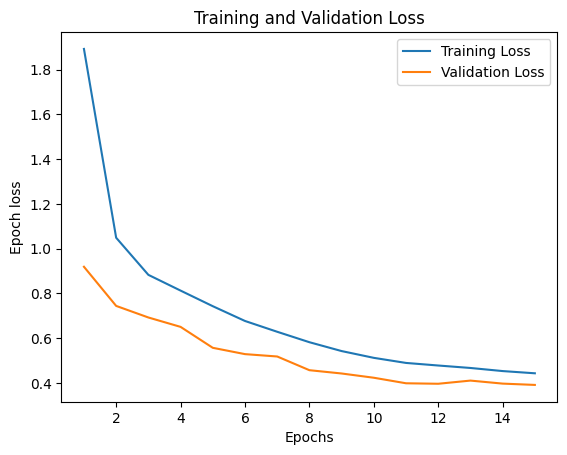

In [25]:
train_model(num_epochs, train_dataset, val_dataset_loader, model, optimizer)

In [26]:
test_results = test_model(model, test_dataset_loader)

<ipython-input-10-ed0af9dd8ef5>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
<ipython-input-10-ed0af9dd8ef5>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['labels'] = torch.tensor(targets_dict['labels'])


mAP50:
tensor(0.3513)
mAP75:
tensor(0.2893)


In [28]:
model_predictions = test_results["predictions"]
for i in range(len(model_predictions)):
  visualisePredictions(i, test_dataset, model_predictions)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
-stop execution-

### Custom Anchor sizes: <a class="anchor" name="custom_anchor"></a>

In [ ]:
#**********************************NEW

# frame of reference
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn

#work around: AttributeError: 'ResNet' object has no attribute 'features'
# backbone = torchvision.models.resnet50(weights="DEFAULT").features
# #https://discuss.pytorch.org/t/change-resnet50s-number-of-output-filters/146644
# backbone.out_channels = 2048

# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

resnet_net = torchvision.models.resnet50(pretrained=True)
modules = list(resnet_net.children())[:-2]
backbone = nn.Sequential(*modules)
backbone.out_channels = 2048

#default
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
anchor_ars = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_ars
)
# sizes=((16, 32, 64, 128, 256),),
#     aspect_ratios=((0.5, 1.0, 2.0),)


# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2)

#keep default
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)


model = FasterRCNN(
    backbone,
    num_classes=4,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
num_epochs = 20

## YOLOv11 Implementation: <a class="anchor" name="YOLOv11"></a>

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from ultralytics import YOLO

In [ ]:
import numpy as np
import random
import torch
#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

In [ ]:
# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/YOLO_11_w_project_data_second/data.yaml", # path to dataset YAML
    epochs=15, # number of training epochs
    imgsz=640, # training image size
    ) # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu

## Appendix A: <a class="anchor" name="AppenA"></a>
Attempts to override FasterRCNN forward() method

In [ ]:
##***************************************TEST
from torchvision.models.detection import FasterRCNN

import warnings

class ModifiedFasterRCNN(FasterRCNN):
  def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError(f"Expected target boxes to be a tensor of shape [N, 4], got {boxes.shape}.")
                else:
                    raise ValueError(f"Expected target boxes to be of type Tensor, got {type(boxes)}.")

        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError(
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}."
                    )

        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return losses, detections
        else:
            #MODIFIED THIS LINE
            return losses, detections

from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers, _mobilenet_extractor
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.resnet import resnet50
from torchvision._internally_replaced_utils import load_state_dict_from_url
from torchvision.models.detection._utils import overwrite_eps

model_urls = {
    "fasterrcnn_resnet50_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
    "fasterrcnn_mobilenet_v3_large_320_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth",
    "fasterrcnn_mobilenet_v3_large_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth",
}

def modified_fasterrcnn_resnet50_fpn(
    pretrained=False, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs
):
    """
    Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.

    Reference: `"Faster R-CNN: Towards Real-Time Object Detection with
    Region Proposal Networks" <https://arxiv.org/abs/1506.01497>`_.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:

        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows, where ``N`` is the number of detections:

        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (``Int64Tensor[N]``): the predicted labels for each detection
        - scores (``Tensor[N]``): the scores of each detection

    For more details on the output, you may refer to :ref:`instance_seg_output`.

    Faster R-CNN is exportable to ONNX for a fixed batch size with inputs images of fixed size.

    Example::

        >>> model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        >>> # For training
        >>> images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
        >>> boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
        >>> labels = torch.randint(1, 91, (4, 11))
        >>> images = list(image for image in images)
        >>> targets = []
        >>> for i in range(len(images)):
        >>>     d = {}
        >>>     d['boxes'] = boxes[i]
        >>>     d['labels'] = labels[i]
        >>>     targets.append(d)
        >>> output = model(images, targets)
        >>> # For inference
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
        >>>
        >>> # optionally, if you want to export the model to ONNX:
        >>> torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

    Args:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
        num_classes (int): number of output classes of the model (including the background)
        pretrained_backbone (bool): If True, returns a model with backbone pre-trained on Imagenet
        trainable_backbone_layers (int): number of trainable (not frozen) resnet layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable. If ``None`` is
            passed (the default) this value is set to 3.
    """
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3
    )

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False

    backbone = resnet50(pretrained=pretrained_backbone, progress=progress, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    #MODIFIED THE LINE BELOW
    model = ModifiedFasterRCNN(backbone, num_classes, **kwargs)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls["fasterrcnn_resnet50_fpn_coco"], progress=progress)
        model.load_state_dict(state_dict)
        overwrite_eps(model, 0.0)
    return model

In [ ]:
#TEST
model = modified_fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 4  #+1 for background - there are 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)